In [1]:
import psycopg2
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from statsmodels.stats.outliers_influence import variance_inflation_factor, OLSInfluence
from statsmodels.stats.diagnostic import het_breuschpagan, durbin_watson
from scipy.stats import shapiro


In [2]:
#replacing PostgreSQL connection details
df= {
    'host': '127.0.0.1',
    'port': '5432',
    'database': 'Health_Condition',
    'user': 'dap',
    'password': 'dap'
}

In [3]:
#connecting to the PostgreSQL database
connection = psycopg2.connect(**df)

In [4]:
sql_query = "SELECT * FROM public.health_condition;"
 
#converting the SQL query result into a DataFrame
df = pd.read_sql_query(sql_query, connection)
 
# Closing the database connection
connection.close()


/var/folders/6g/rscqc8wd2cx489zg__dgy0th0000gn/T/ipykernel_41648/367540694.py:4: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(sql_query, connection)


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2516 entries, 0 to 2515
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   measures        2516 non-null   object 
 1   panel           2516 non-null   object 
 2   panel_num       2516 non-null   int64  
 3   unit            2516 non-null   object 
 4   unit_num        2516 non-null   int64  
 5   stub_name       2516 non-null   object 
 6   stub_name_num   2516 non-null   int64  
 7   stub_label      2516 non-null   object 
 8   stub_label_num  2516 non-null   float64
 9   years           2516 non-null   object 
 10  years_num       2516 non-null   int64  
 11  age             2516 non-null   object 
 12  age_num         2516 non-null   float64
 13  estimate        2516 non-null   float64
 14  se              2516 non-null   float64
dtypes: float64(4), int64(4), object(7)
memory usage: 295.0+ KB


In [6]:
#checking for the missing values
missing_values = df.isnull().sum()

(missing_values)


measures          0
panel             0
panel_num         0
unit              0
unit_num          0
stub_name         0
stub_name_num     0
stub_label        0
stub_label_num    0
years             0
years_num         0
age               0
age_num           0
estimate          0
se                0
dtype: int64

In [7]:
df

,measures,panel,panel_num,unit,unit_num,stub_name,stub_name_num,stub_label,stub_label_num,years,years_num,age,age_num,estimate,se
0,Health conditions among children under age 18,ADHD among persons under 18 years,3,"Percent of children, crude",1,Age,1,10-17 years,1.22,1997-1999,1,10-17 years,2.2,7.6,0.2
1,Health conditions among children under age 18,ADHD among persons under 18 years,3,"Percent of children, crude",1,Age,1,10-17 years,1.22,2000-2002,2,10-17 years,2.2,9.0,0.3
2,Health conditions among children under age 18,ADHD among persons under 18 years,3,"Percent of children, crude",1,Age,1,10-17 years,1.22,2003-2005,3,10-17 years,2.2,8.9,0.3
3,Health conditions among children under age 18,Current asthma among persons under 18 years,1,"Percent of children, crude",1,Total,0,Under 18 years,0.00,2003-2005,3,Under 18 years,0.0,8.7,0.2
4,Health conditions among children under age 18,Current asthma among persons under 18 years,1,"Percent of children, crude",1,Total,0,Under 18 years,0.00,2006-2008,4,Under 18 years,0.0,9.3,0.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2511,Health conditions among children under age 18,Ear infections among persons under 18 years,8,"Percent of children, crude",1,Health insurance status at the time of interview,6,Uninsured,6.20,2012-2014,10,Under 18 years,0.0,4.4,0.5
2512,Health conditions among children under age 18,Ear infections among persons under 18 years,8,"Percent of children, crude",1,Health insurance status at the time of interview,6,Uninsured,6.20,2013-2015,11,Under 18 years,0.0,4.4,0.6
2513,Health conditions among children under age 18,Ear infections among persons under 18 years,8,"Percent of children, crude",1,Health insurance status at the time of interview,6,Uninsured,6.20,2014-2016,12,Under 18 years,0.0,3.6,0.5
2514,Health conditions among children under age 18,Ear infections among persons under 18 years,8,"Percent of children, crude",1,Health insurance status at the time of interview,6,Uninsured,6.20,2015-2017,13,Under 18 years,0.0,3.2,0.6


In [8]:
def remove_outliers(df):
    numerical = df.select_dtypes(include=['float64', 'int64'])
    for column in numerical.columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    return df

In [9]:
df=remove_outliers(df)

In [10]:
df

,measures,panel,panel_num,unit,unit_num,stub_name,stub_name_num,stub_label,stub_label_num,years,years_num,age,age_num,estimate,se
3,Health conditions among children under age 18,Current asthma among persons under 18 years,1,"Percent of children, crude",1,Total,0,Under 18 years,0.0,2003-2005,3,Under 18 years,0.0,8.7,0.2
4,Health conditions among children under age 18,Current asthma among persons under 18 years,1,"Percent of children, crude",1,Total,0,Under 18 years,0.0,2006-2008,4,Under 18 years,0.0,9.3,0.2
5,Health conditions among children under age 18,Current asthma among persons under 18 years,1,"Percent of children, crude",1,Total,0,Under 18 years,0.0,2007-2009,5,Under 18 years,0.0,9.4,0.2
6,Health conditions among children under age 18,Current asthma among persons under 18 years,1,"Percent of children, crude",1,Total,0,Under 18 years,0.0,2008-2010,6,Under 18 years,0.0,9.5,0.2
7,Health conditions among children under age 18,Current asthma among persons under 18 years,1,"Percent of children, crude",1,Total,0,Under 18 years,0.0,2009-2011,7,Under 18 years,0.0,9.5,0.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2511,Health conditions among children under age 18,Ear infections among persons under 18 years,8,"Percent of children, crude",1,Health insurance status at the time of interview,6,Uninsured,6.2,2012-2014,10,Under 18 years,0.0,4.4,0.5
2512,Health conditions among children under age 18,Ear infections among persons under 18 years,8,"Percent of children, crude",1,Health insurance status at the time of interview,6,Uninsured,6.2,2013-2015,11,Under 18 years,0.0,4.4,0.6
2513,Health conditions among children under age 18,Ear infections among persons under 18 years,8,"Percent of children, crude",1,Health insurance status at the time of interview,6,Uninsured,6.2,2014-2016,12,Under 18 years,0.0,3.6,0.5
2514,Health conditions among children under age 18,Ear infections among persons under 18 years,8,"Percent of children, crude",1,Health insurance status at the time of interview,6,Uninsured,6.2,2015-2017,13,Under 18 years,0.0,3.2,0.6


In [11]:
df.drop(['measures'], axis=1, inplace=True)

In [12]:
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns
print("Numerical columns:")
print(numerical_cols)

# Print categorical columns
categorical_cols = df.select_dtypes(include=['object']).columns
print("Categorical columns:")
print(categorical_cols)

Numerical columns:
Index(['panel_num', 'unit_num', 'stub_name_num', 'stub_label_num', 'years_num',
       'age_num', 'estimate', 'se'],
      dtype='object')
Categorical columns:
Index(['panel', 'unit', 'stub_name', 'stub_label', 'years', 'age'], dtype='object')


In [13]:
from sklearn.preprocessing import LabelEncoder

# Initialize the LabelEncoder
le = LabelEncoder()

# Applying LabelEncoder to each categorical column
for col in categorical_cols:
    df[col] = le.fit_transform(df[col])

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1956 entries, 3 to 2515
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   panel           1956 non-null   int64  
 1   panel_num       1956 non-null   int64  
 2   unit            1956 non-null   int64  
 3   unit_num        1956 non-null   int64  
 4   stub_name       1956 non-null   int64  
 5   stub_name_num   1956 non-null   int64  
 6   stub_label      1956 non-null   int64  
 7   stub_label_num  1956 non-null   float64
 8   years           1956 non-null   int64  
 9   years_num       1956 non-null   int64  
 10  age             1956 non-null   int64  
 11  age_num         1956 non-null   float64
 12  estimate        1956 non-null   float64
 13  se              1956 non-null   float64
dtypes: float64(4), int64(10)
memory usage: 229.2 KB


In [15]:
# Calculate the correlation matrix
correlation_matrix = df.corr()

# Display the correlation matrix
print(correlation_matrix)

                   panel  panel_num  unit  unit_num  stub_name  stub_name_num  \
panel           1.000000   0.549262   NaN       NaN   0.012759      -0.000719   
panel_num       0.549262   1.000000   NaN       NaN   0.028448      -0.008500   
unit                 NaN        NaN   NaN       NaN        NaN            NaN   
unit_num             NaN        NaN   NaN       NaN        NaN            NaN   
stub_name       0.012759   0.028448   NaN       NaN   1.000000      -0.806182   
stub_name_num  -0.000719  -0.008500   NaN       NaN  -0.806182       1.000000   
stub_label      0.018222   0.008572   NaN       NaN  -0.091464      -0.169193   
stub_label_num -0.003172  -0.008909   NaN       NaN  -0.796433       0.997533   
years           0.008647  -0.051353   NaN       NaN   0.008252      -0.003425   
years_num       0.008647  -0.051353   NaN       NaN   0.008252      -0.003425   
age             0.034303   0.053941   NaN       NaN   0.214158       0.215817   
age_num              NaN    

In [16]:
df.drop(['unit'], axis=1, inplace=True)
df.drop(['unit_num'], axis=1, inplace=True)
df.drop(['age_num'], axis=1, inplace=True)

In [17]:
# Calculate the correlation matrix
correlation_matrix = df.corr()

# Display the correlation matrix
print(correlation_matrix)


                   panel  panel_num  stub_name  stub_name_num  stub_label  \
panel           1.000000   0.549262   0.012759      -0.000719    0.018222   
panel_num       0.549262   1.000000   0.028448      -0.008500    0.008572   
stub_name       0.012759   0.028448   1.000000      -0.806182   -0.091464   
stub_name_num  -0.000719  -0.008500  -0.806182       1.000000   -0.169193   
stub_label      0.018222   0.008572  -0.091464      -0.169193    1.000000   
stub_label_num -0.003172  -0.008909  -0.796433       0.997533   -0.204601   
years           0.008647  -0.051353   0.008252      -0.003425   -0.011886   
years_num       0.008647  -0.051353   0.008252      -0.003425   -0.011886   
age             0.034303   0.053941   0.214158       0.215817    0.126421   
estimate        0.260912   0.200075   0.000657       0.001391    0.045023   
se              0.060214   0.010447  -0.033704       0.151692   -0.233525   

                stub_label_num     years  years_num       age  estimate  \


In [18]:
#dropping the target feature and creating seperate variable for the target feature
X = df.drop(columns=['estimate'])
Y =df['estimate']

In [19]:
#Viewing the X variable columns
X

,panel,panel_num,stub_name,stub_name_num,stub_label,stub_label_num,years,years_num,age,se
3,2,1,6,0,19,0.0,2,3,1,0.2
4,2,1,6,0,19,0.0,3,4,1,0.2
5,2,1,6,0,19,0.0,4,5,1,0.2
6,2,1,6,0,19,0.0,5,6,1,0.2
7,2,1,6,0,19,0.0,6,7,1,0.2
...,...,...,...,...,...,...,...,...,...,...
2511,3,8,1,6,20,6.2,9,10,1,0.5
2512,3,8,1,6,20,6.2,10,11,1,0.6
2513,3,8,1,6,20,6.2,11,12,1,0.5
2514,3,8,1,6,20,6.2,12,13,1,0.6


In [20]:
#Viewing target variable
Y

3       8.7
4       9.3
5       9.4
6       9.5
7       9.5
       ... 
2511    4.4
2512    4.4
2513    3.6
2514    3.2
2515    2.9
Name: estimate, Length: 1956, dtype: float64

In [21]:
#viewing stats of target feature
Y.describe()

count    1956.000000
mean        8.235225
std         4.140312
min         1.100000
25%         5.000000
50%         6.900000
75%        10.900000
max        20.300000
Name: estimate, dtype: float64

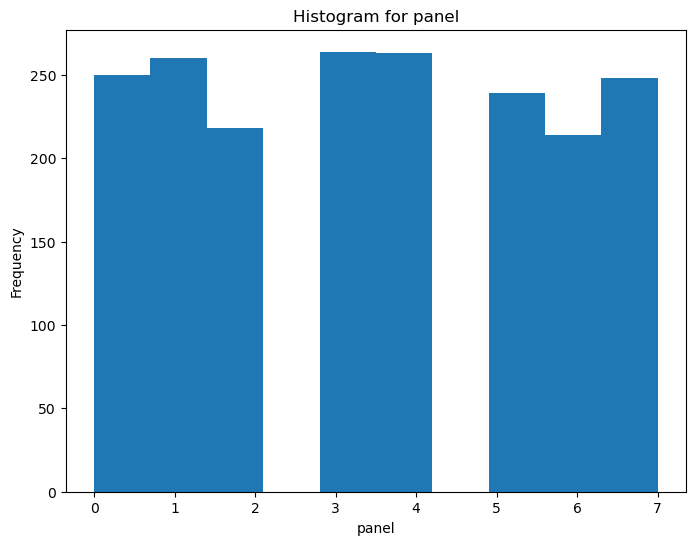

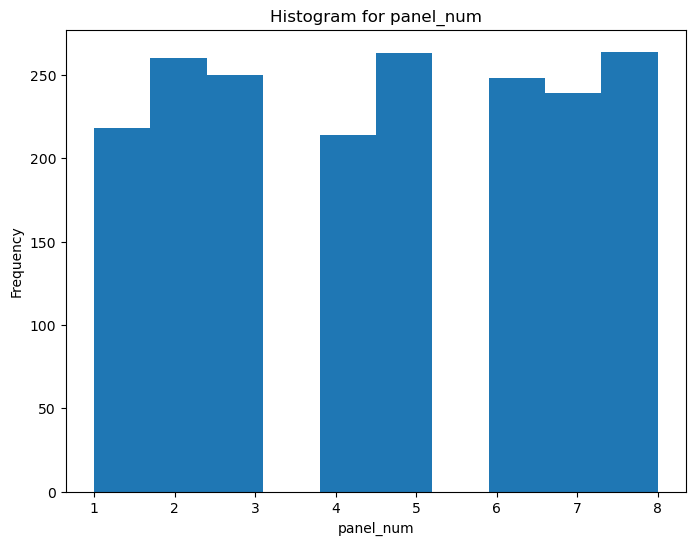

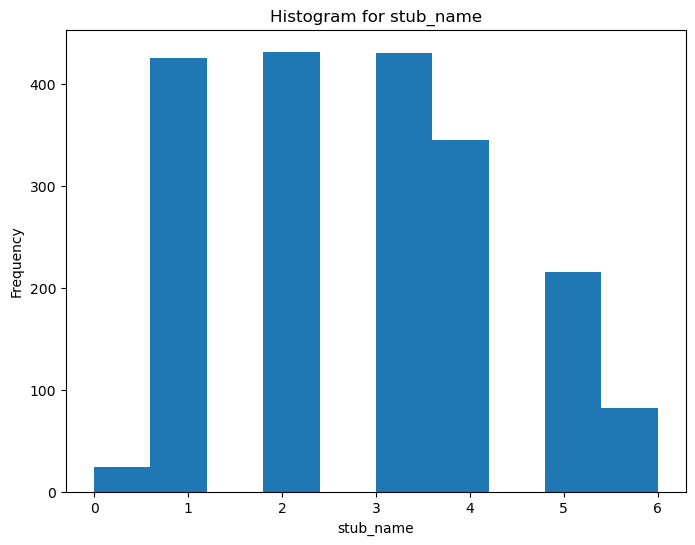

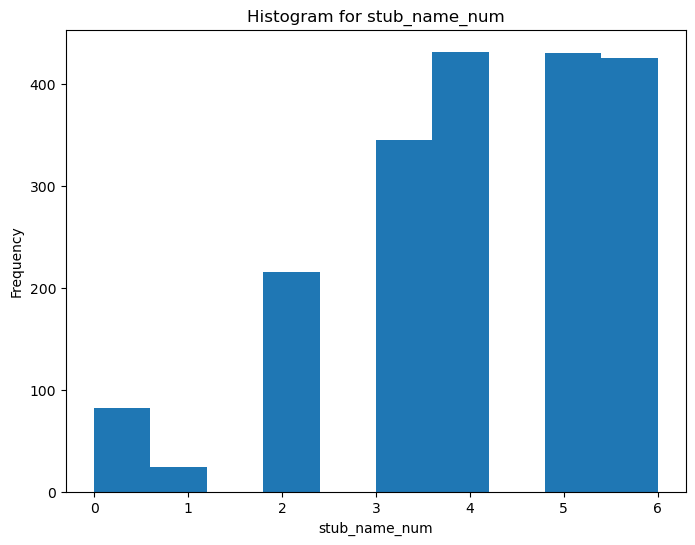

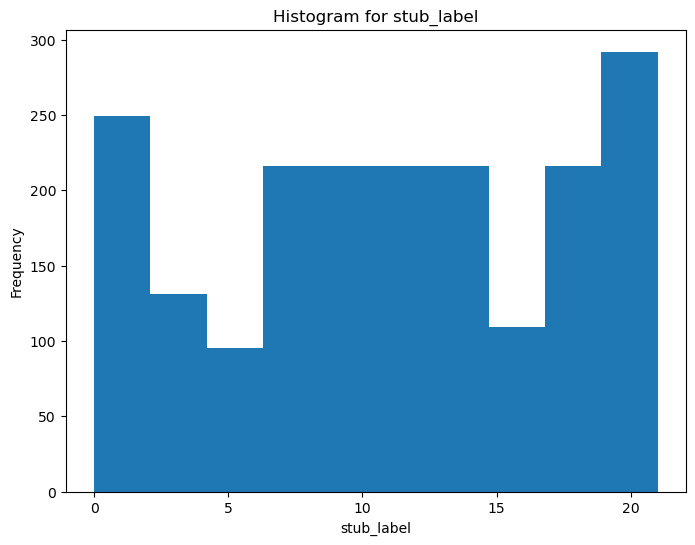

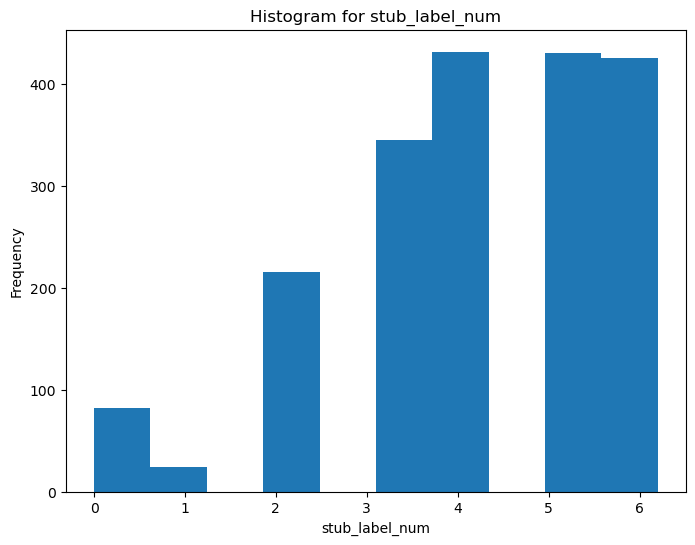

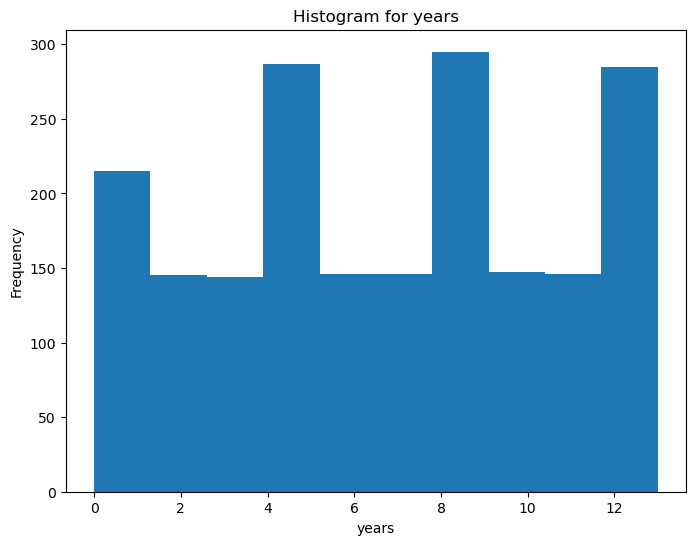

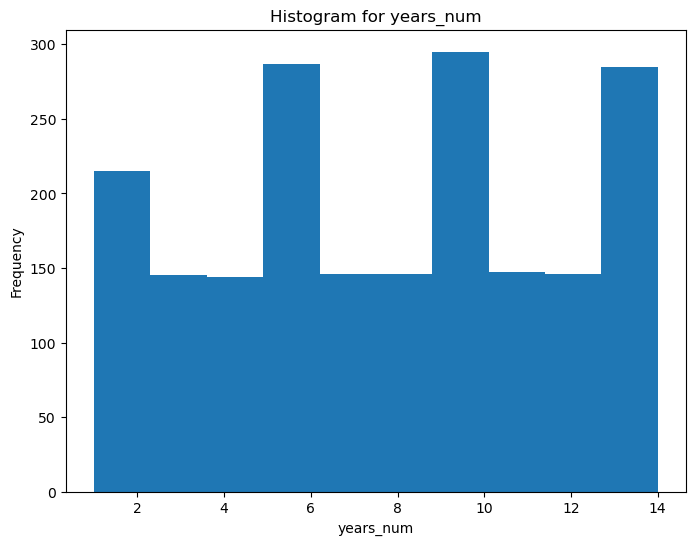

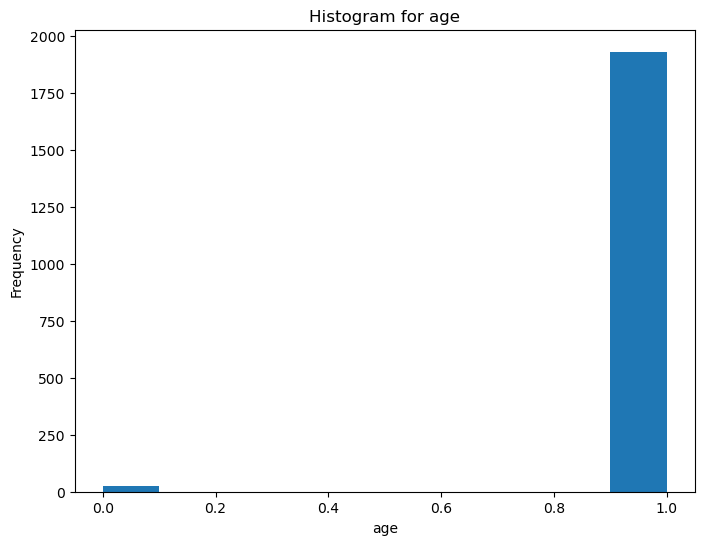

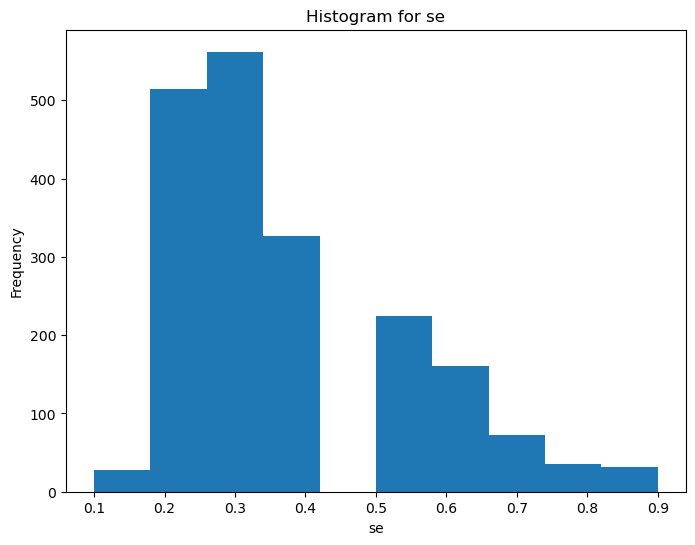

In [22]:
#Figure 2 for reference
#plotting histogram for X vairable columns
for column in X:
    plt.figure(figsize=(8, 6))  
    plt.hist(X[column]) 
    plt.title(f'Histogram for {column}')  
    plt.xlabel(column)  
    plt.ylabel('Frequency')
    plt.show()


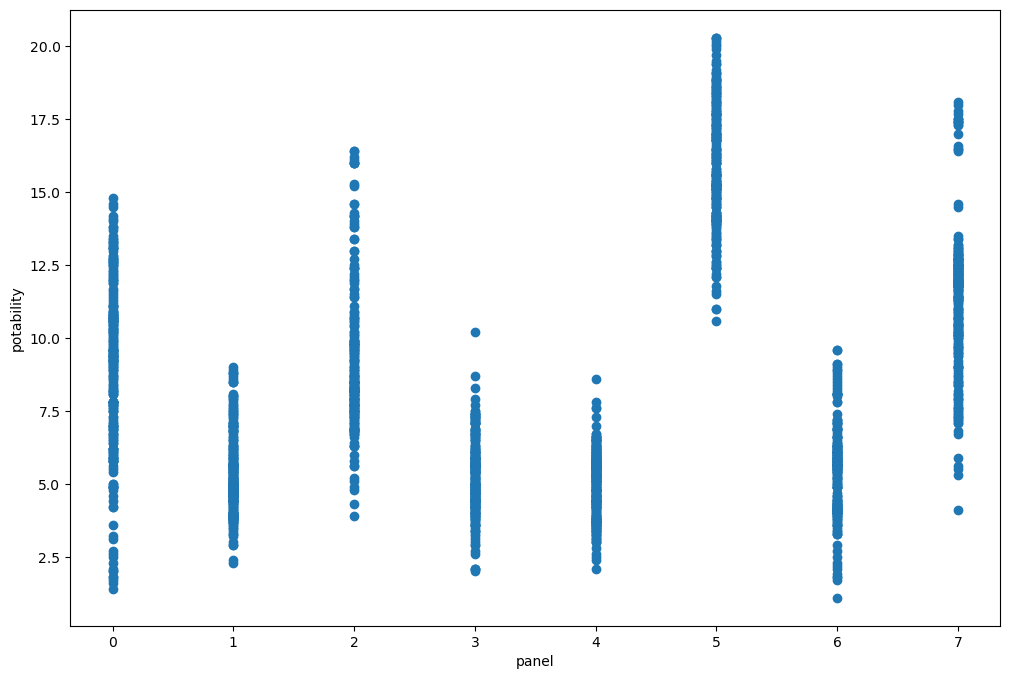

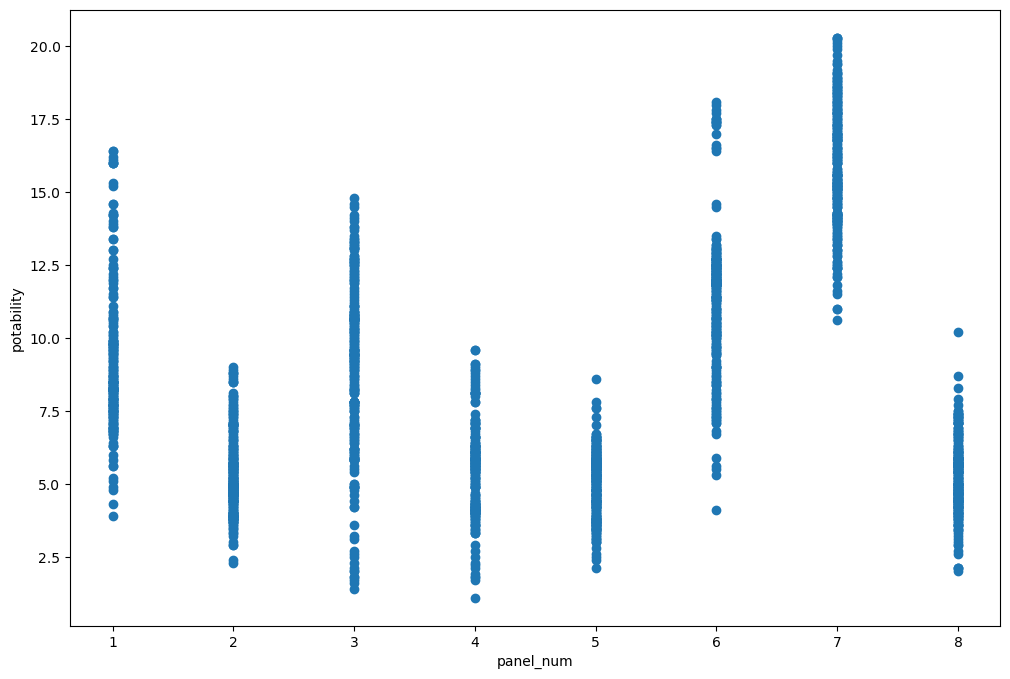

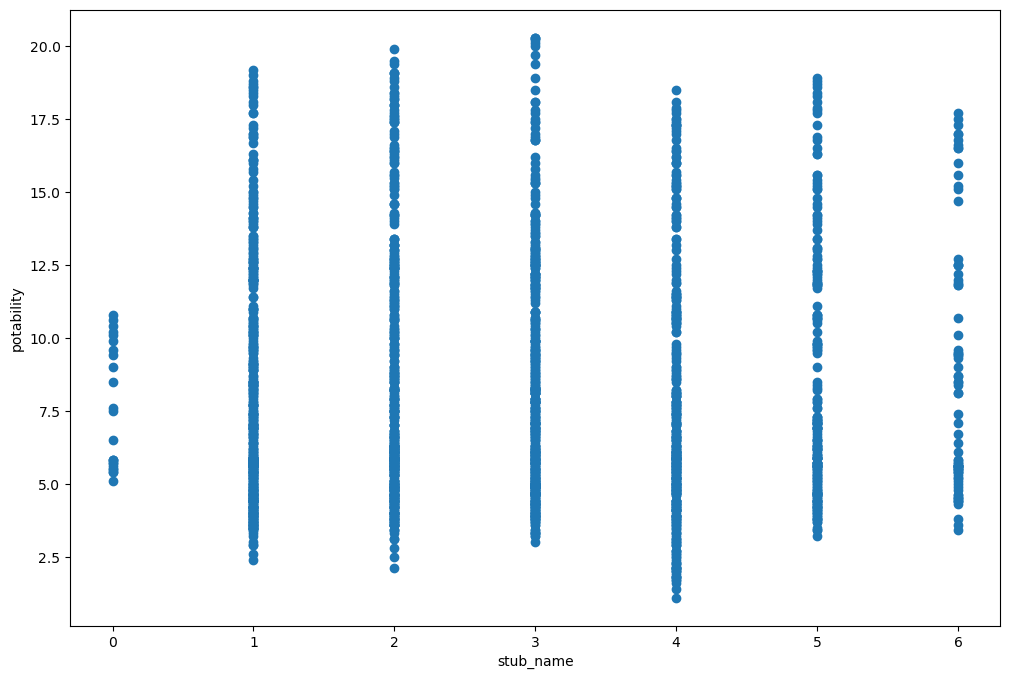

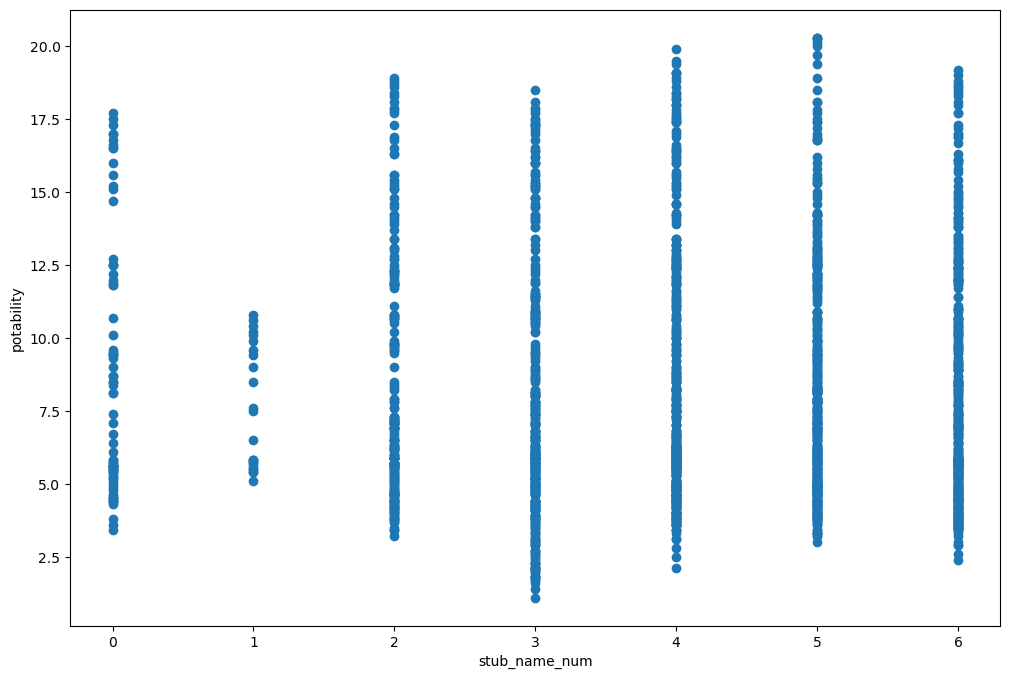

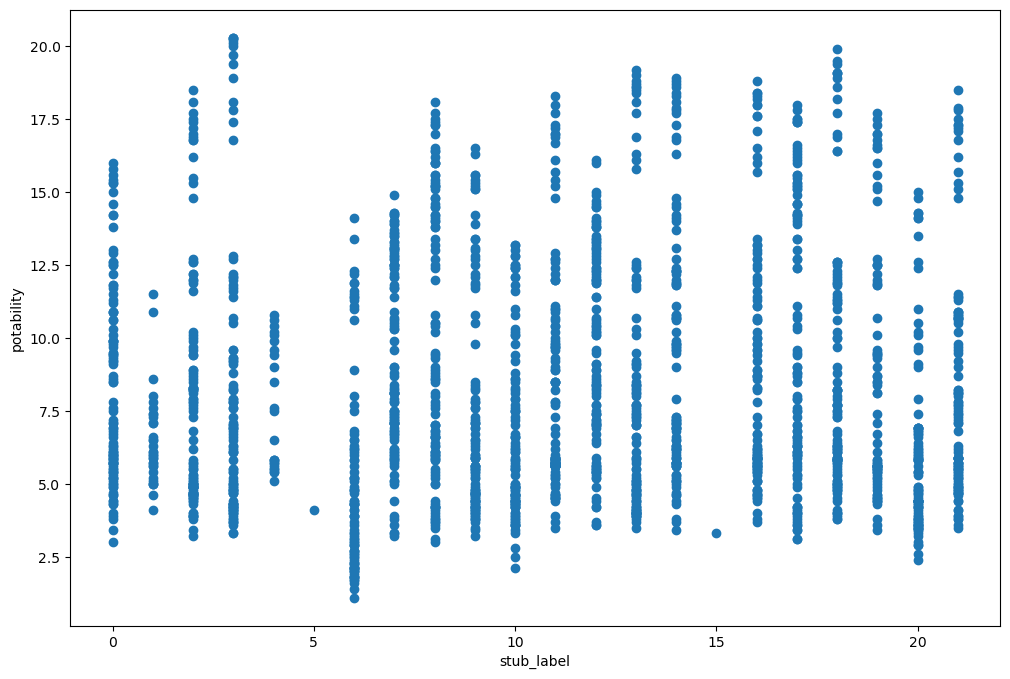

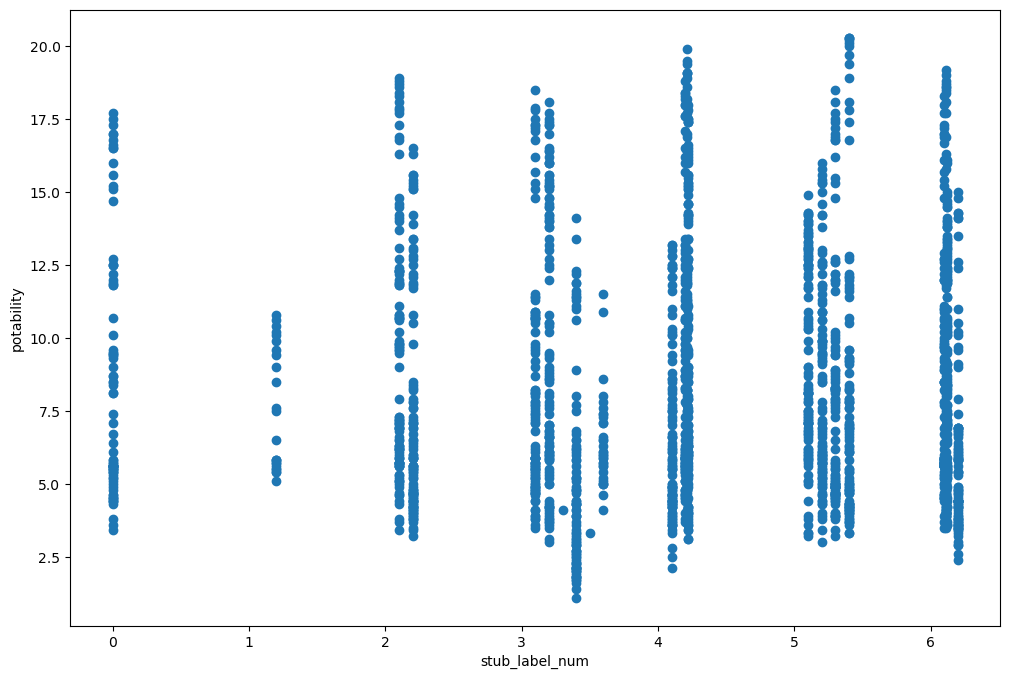

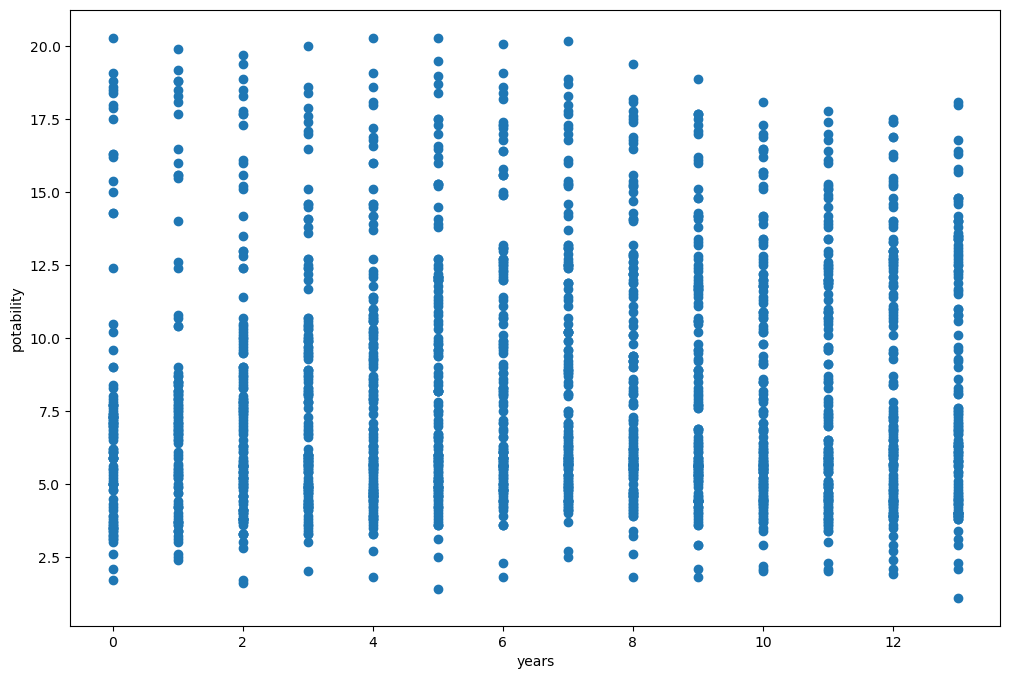

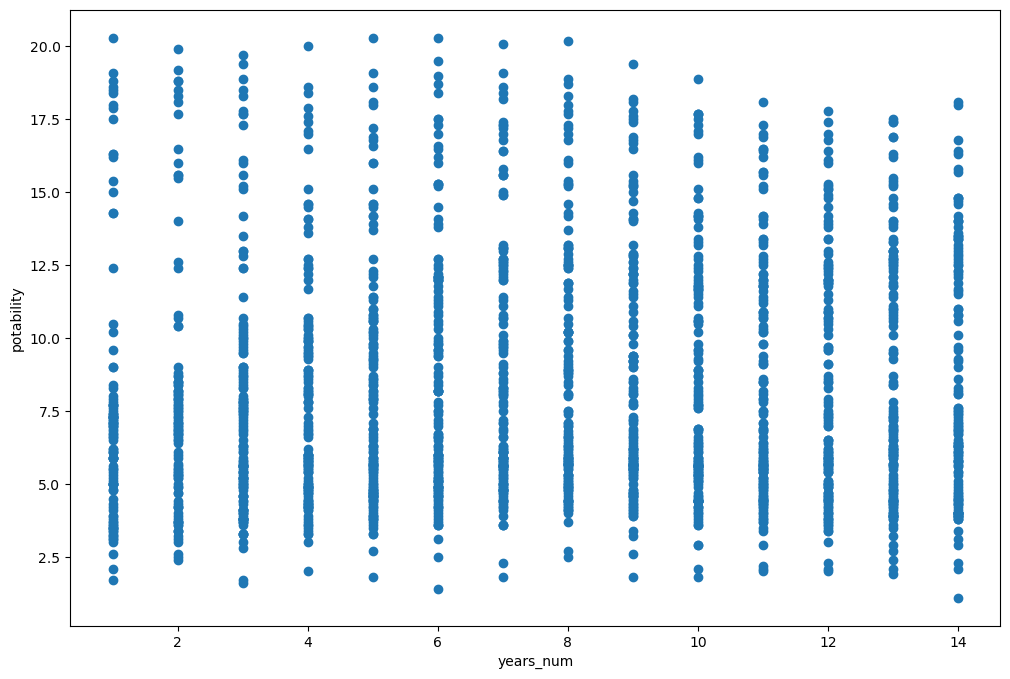

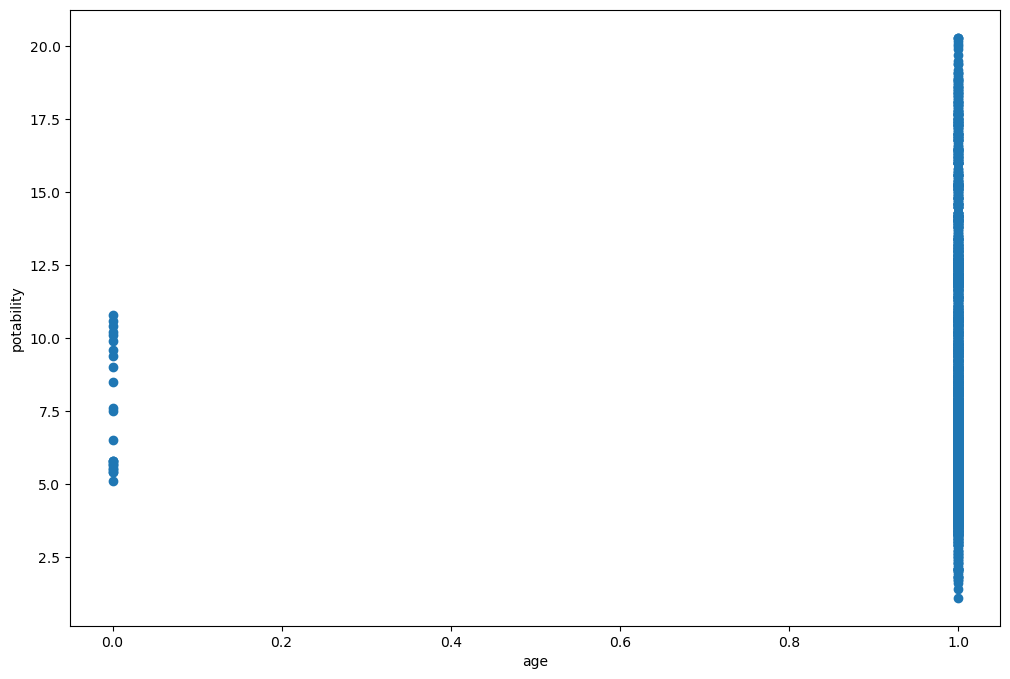

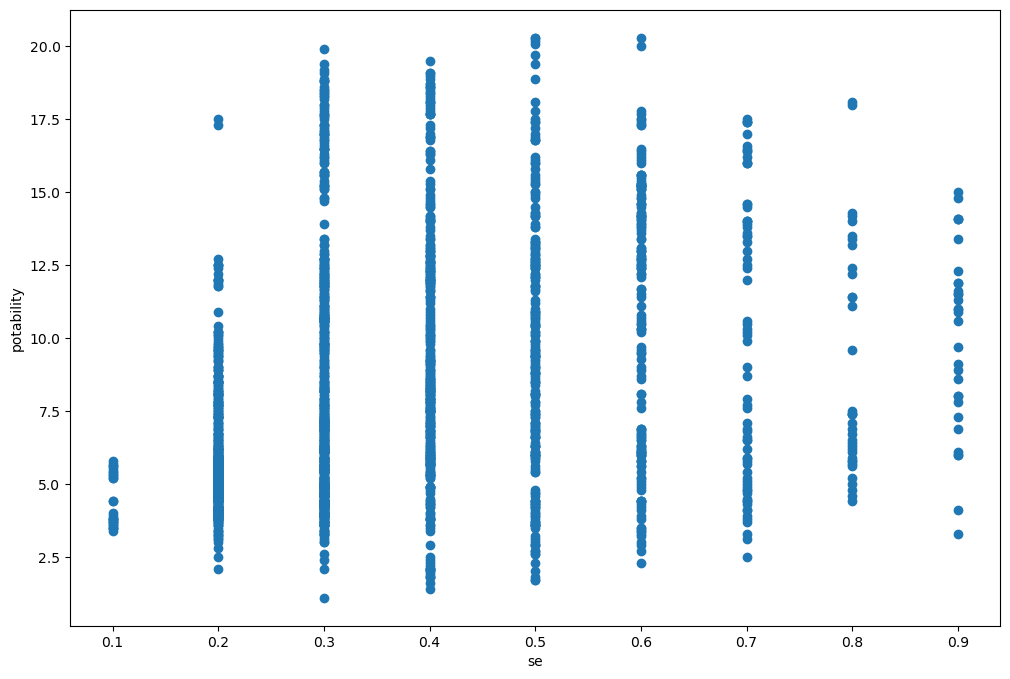

In [23]:
#figure 3.1 for reference
#plotting scatter plot of target feature vs dependent feature
for column in X:
    plt.figure(figsize=(12, 8))
    plt.scatter(X[column], Y)
    plt.ylabel('potability')
    plt.xlabel(column)
    plt.show()


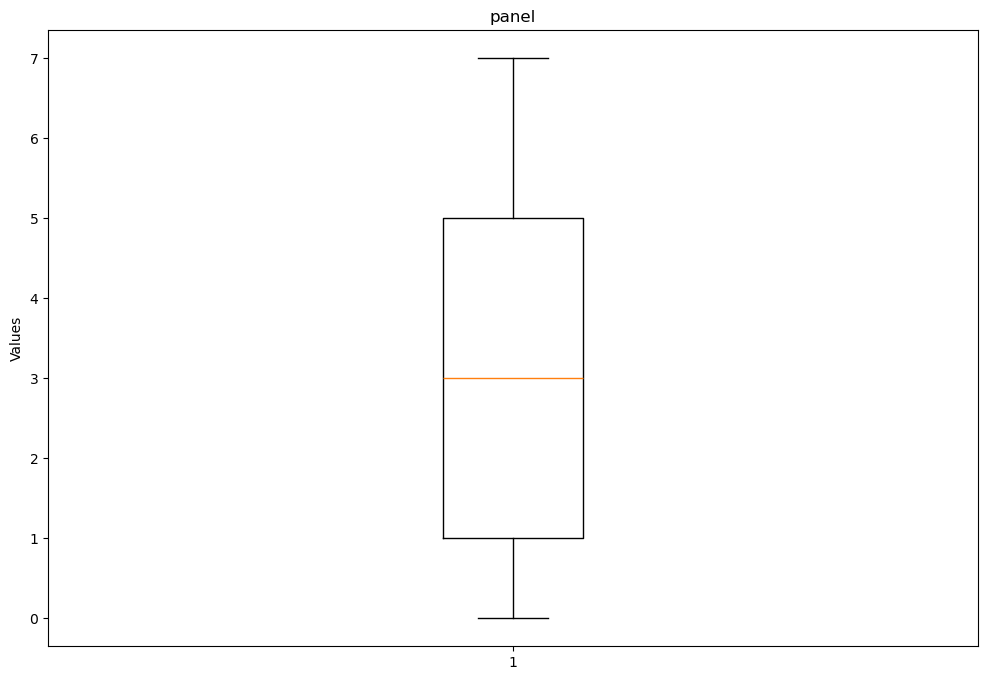

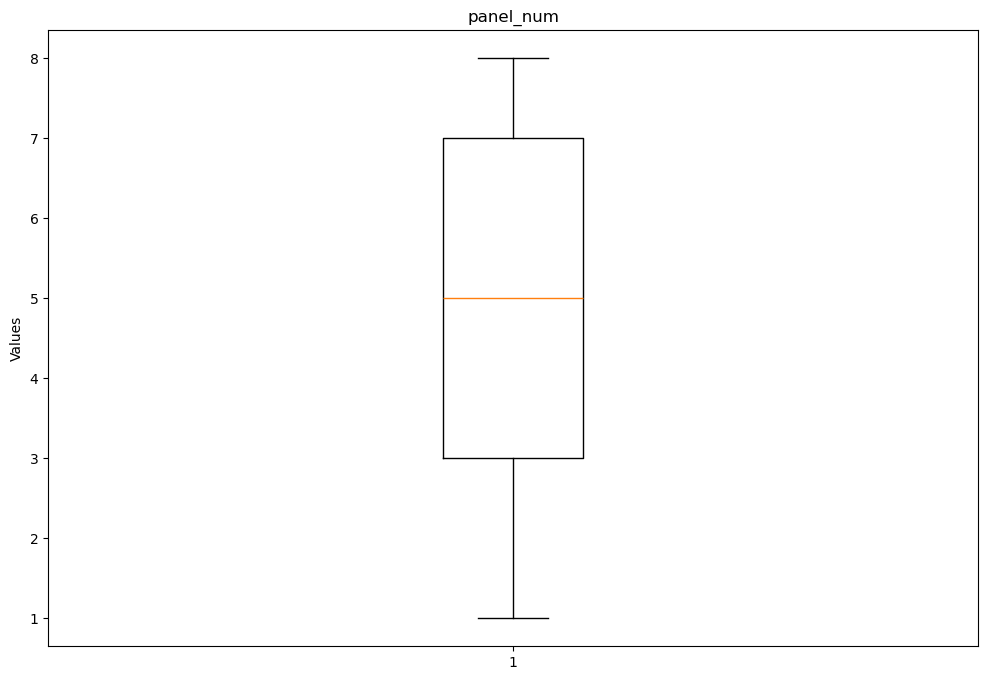

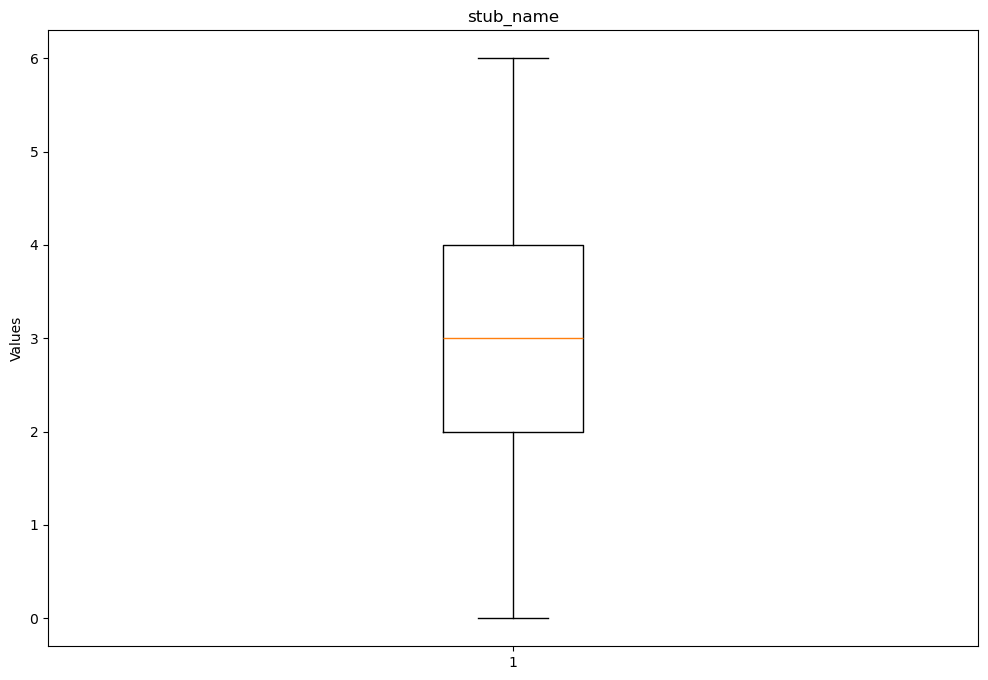

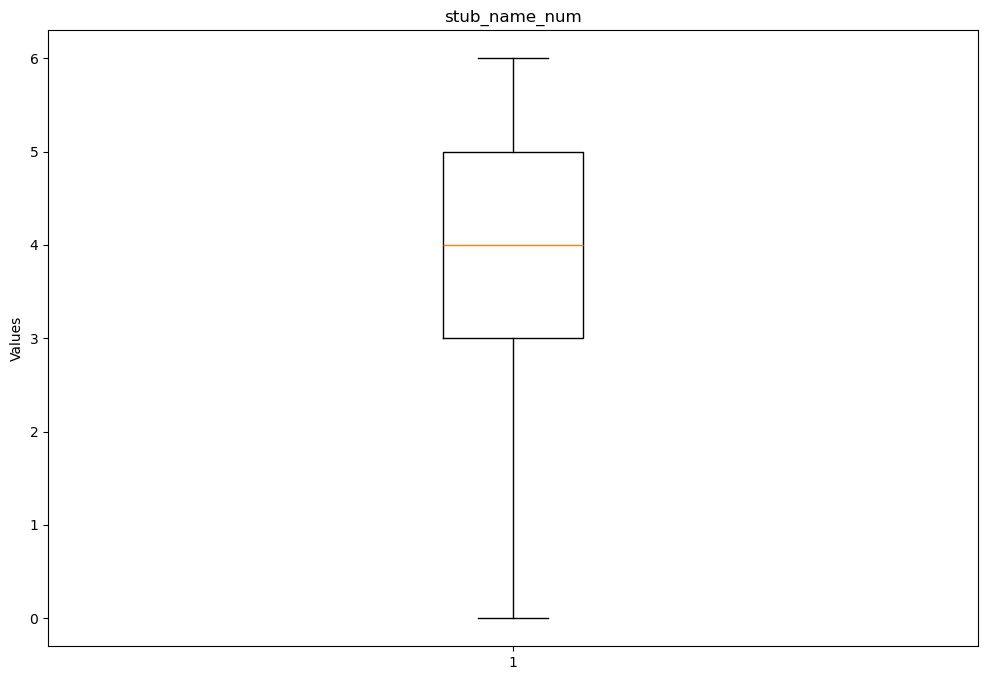

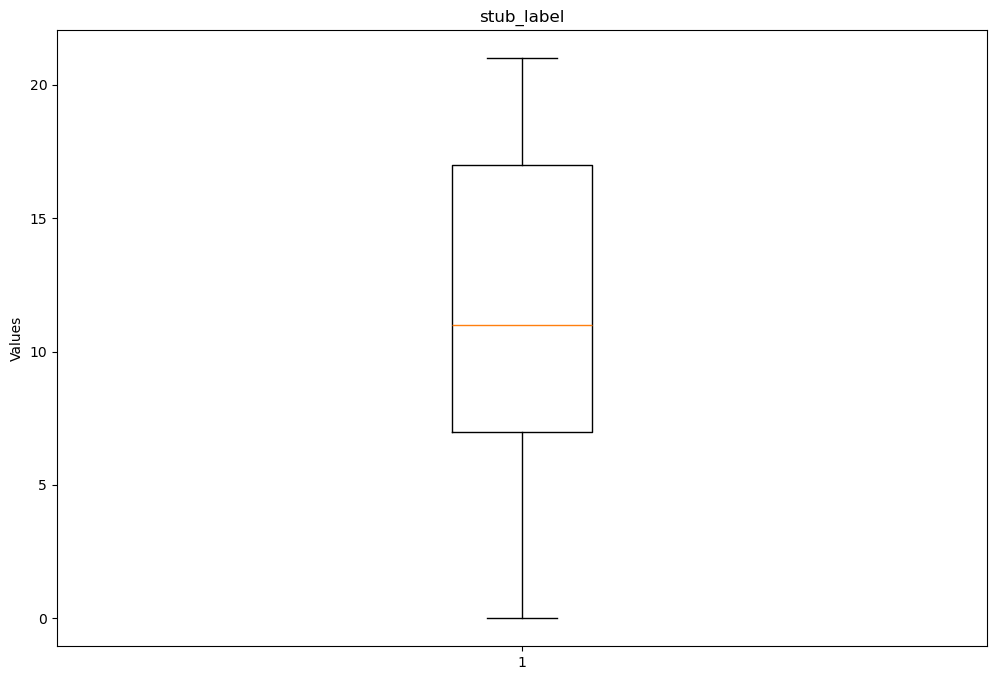

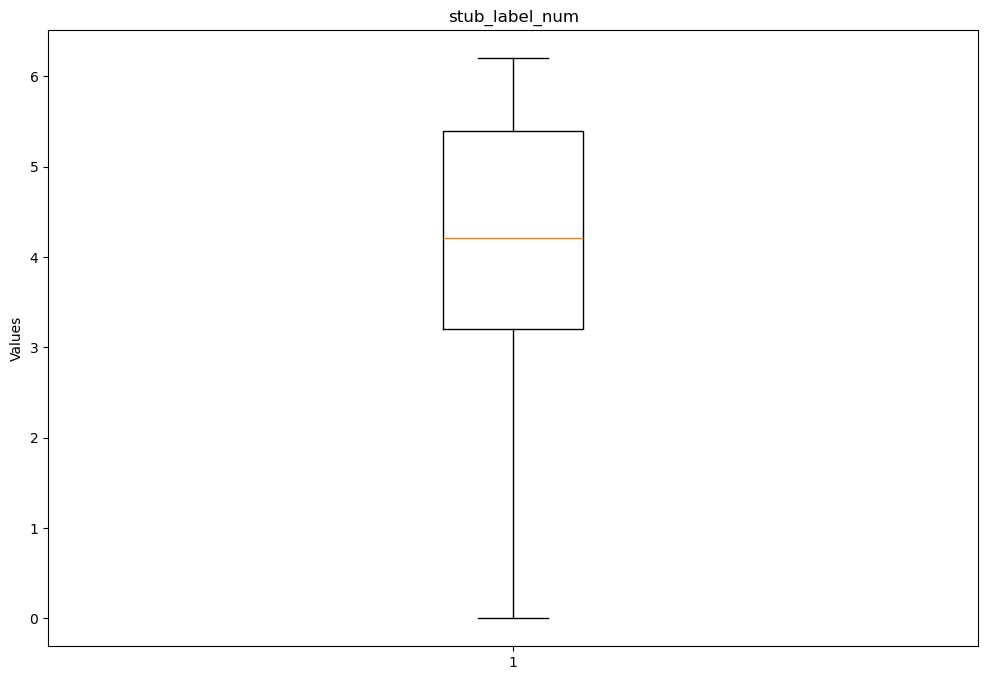

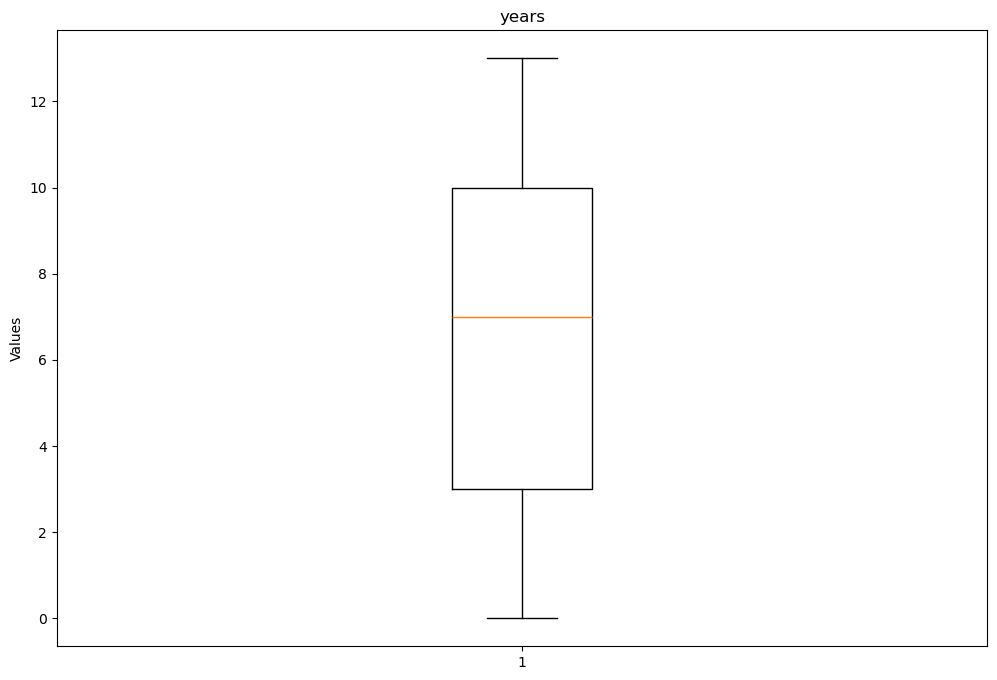

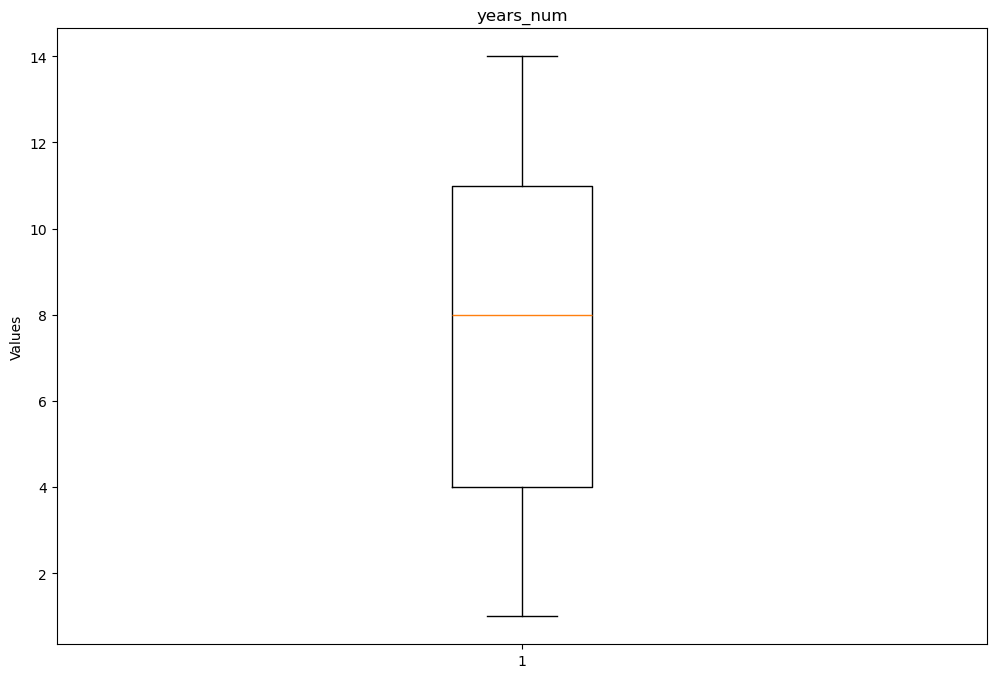

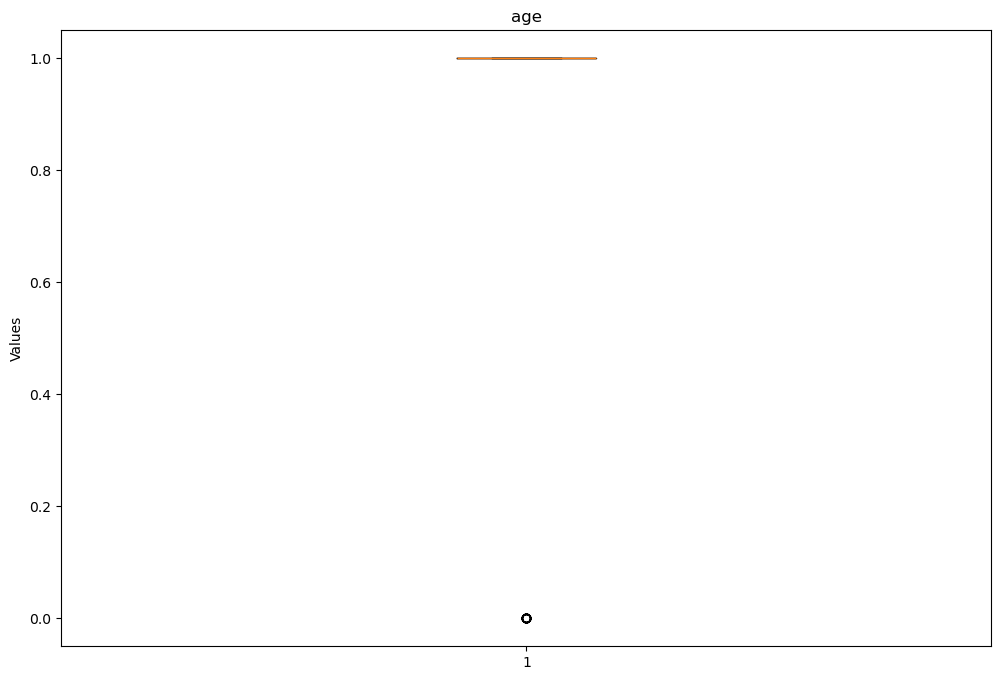

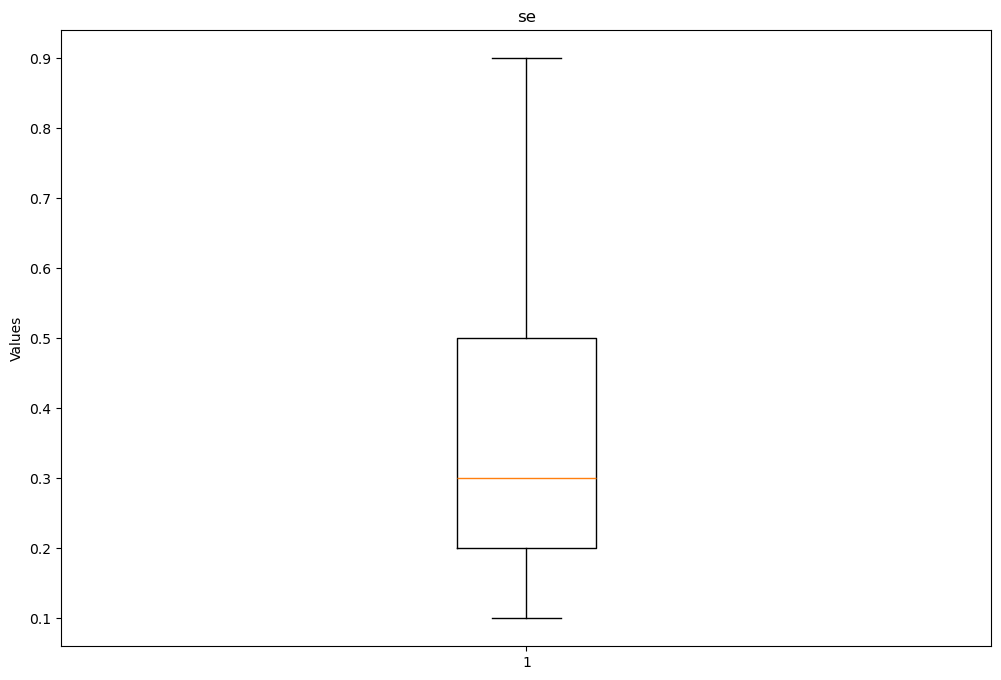

In [24]:
X_numeric = X.select_dtypes(include=[np.number])

# Plotting boxplot for all numeric columns in X
for column in X_numeric:
    plt.figure(figsize=(12, 8))
    plt.boxplot(X_numeric[column].dropna())  # Ensure to drop NA values to avoid plotting issues
    plt.title(column)
    plt.ylabel('Values')
    plt.show()

In [25]:

#splitting the data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=23135433)



In [26]:
# Using Min-Max Scaling to normalize features in the training set (X_train) and test set (X_test)
# Initialize the MinMaxScaler
scaler = MinMaxScaler()
# Fit and transform the training features and update the DataFrame
scaled_features_train = scaler.fit_transform(X_train)
X_train = pd.DataFrame(scaled_features_train, columns=X_train.columns, index=X_train.index)
# Initialize a new MinMaxScaler for the test set
scaler = MinMaxScaler()
# Fit and transform the test features and update the DataFrame
scaled_features_test = scaler.fit_transform(X_test)
X_test = pd.DataFrame(scaled_features_test, columns=X_test.columns, index=X_test.index)

In [27]:
# Performing Ordinary Least Squares (OLS) regression on the training set (X_train, Y_train)
# Figure 9 of the report is for reference
X_train = sm.add_constant(X_train)
model = sm.OLS(Y_train, X_train).fit()
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:               estimate   R-squared:                       0.268
Model:                            OLS   Adj. R-squared:                  0.263
Method:                 Least Squares   F-statistic:                     55.28
Date:                Thu, 25 Apr 2024   Prob (F-statistic):           6.29e-86
Time:                        20:09:17   Log-Likelihood:                -3671.0
No. Observations:                1369   AIC:                             7362.
Df Residuals:                    1359   BIC:                             7414.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              8.4855      0.941      9.

In [28]:
# Dropping the columns with high VIF from X_train
X_train.drop(['years_num'], axis=1, inplace=True)
X_train.drop(['years'], axis=1, inplace=True)
X_train.drop(['age'], axis=1, inplace=True)
X_train.drop(['stub_name'], axis=1, inplace=True)
X_train.drop(['stub_label'], axis=1, inplace=True)

In [29]:
# Performing Ordinary Least Squares (OLS) regression on the training set (X_train, Y_train)
# Figure 9 of the report is for reference
X_train = sm.add_constant(X_train)
model = sm.OLS(Y_train, X_train).fit()
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:               estimate   R-squared:                       0.264
Model:                            OLS   Adj. R-squared:                  0.262
Method:                 Least Squares   F-statistic:                     97.88
Date:                Thu, 25 Apr 2024   Prob (F-statistic):           2.88e-88
Time:                        20:09:17   Log-Likelihood:                -3674.5
No. Observations:                1369   AIC:                             7361.
Df Residuals:                    1363   BIC:                             7392.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              6.3424      0.352     18.

In [30]:
X_test.drop(['years_num'], axis=1, inplace=True)
X_test.drop(['years'], axis=1, inplace=True)
X_test.drop(['age'], axis=1, inplace=True)
X_test.drop(['stub_name'], axis=1, inplace=True)
X_test.drop(['stub_label'], axis=1, inplace=True)

In [31]:
# Adding a constant term to the features in the X_test
X_test = sm.add_constant(X_test)
# Predicting the target variable for the test set using the fitted OLS model
Y_pred=model.predict(X_test)
Y_pred

1351     7.635037
767      9.622493
1105    10.158473
1857    11.173898
1822    10.523134
          ...    
234      4.786510
1923    10.842828
825     13.001716
551      4.766468
440      6.073591
Length: 587, dtype: float64

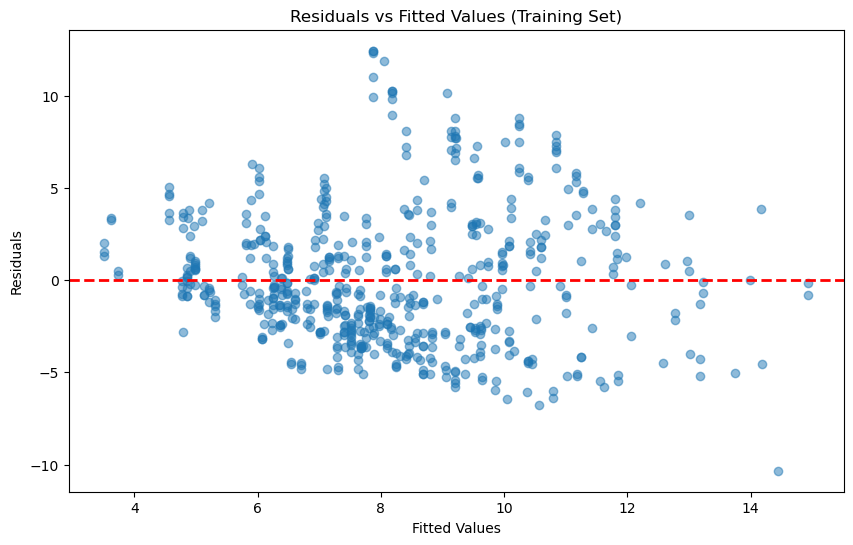

In [32]:
# Visualization of  residuals vs fitted values for the training dataset
# Figure 13 of the report is for reference
residuals_train = Y_test- Y_pred   # Calculate residuals by subtracting predicted values from actual values
# Create a scatter plot of residuals against fitted values
plt.figure(figsize=(10, 6))
plt.scatter(Y_pred, residuals_train, alpha=0.5)
plt.axhline(y=0, color='red', linestyle='--', linewidth=2)  # Add a horizontal line at y=0 for reference
plt.title('Residuals vs Fitted Values (Training Set)')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.show()

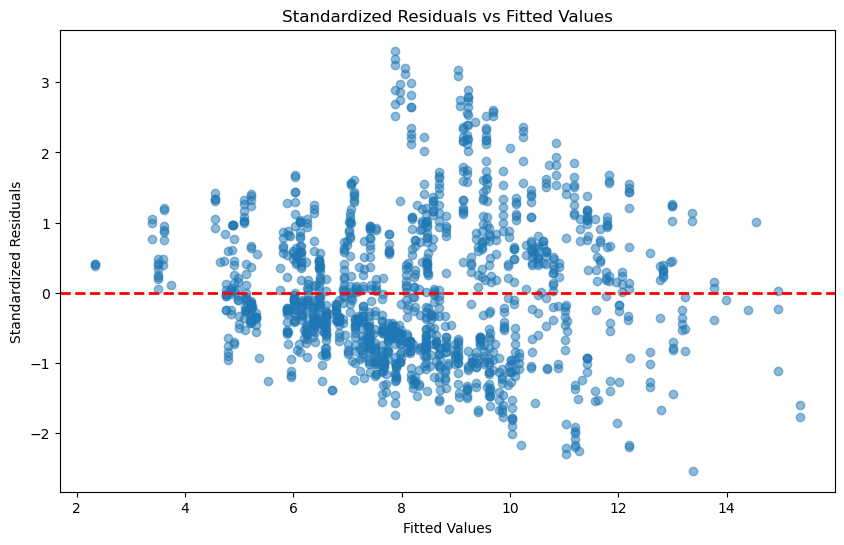

In [33]:
# Visualization standardized residuals vs fitted values
# Figure 14 of the report is for reference
standardized_residuals = model.get_influence().resid_studentized_internal  # Obtain standardized residuals using the influence object from the model
# Create a scatter plot of standardized residuals against fitted values
fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(model.fittedvalues, standardized_residuals, alpha=0.5)
ax.axhline(y=0, color='red', linestyle='--', linewidth=2)
ax.set_title('Standardized Residuals vs Fitted Values')
ax.set_xlabel('Fitted Values')
ax.set_ylabel('Standardized Residuals')
plt.show()

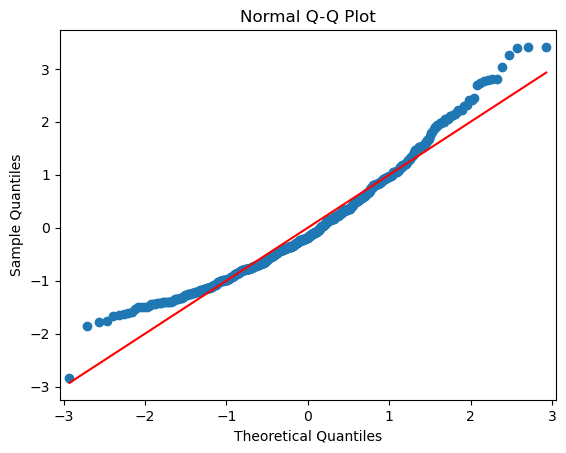

In [34]:
# Visualization of NQQ Plot
# Figure 12 of the report is for reference
residuals = Y_test - Y_pred
sm.qqplot(residuals, line='s', fit=True)
plt.title('Normal Q-Q Plot')
plt.show()

In [35]:
#Calculating mean absolute error and rounding off upto 2 decimal places
round(
mean_absolute_error( Y_test,Y_pred),2)



2.89

In [36]:
#Calculating the range
max(Y_test) - min(Y_test)



18.400000000000002

In [37]:
#Calculating mean absolute percentage error and rounding off upto 2 decimal places
round(
mean_absolute_percentage_error( Y_test,Y_pred),2)




0.43

In [38]:
# Calculate Mean Squared Error (MSE)
mse = round(mean_squared_error(Y_test,Y_pred),2)
mse



13.25

In [39]:
# Calculate Residual Standard Error (RSE)
rse = round(np.sqrt(mse),2)
rse

3.64

In [40]:
# Performing the Breusch-Pagan test for heteroscedasticity which can invalidate some statistical tests if present
residuals = model.resid
_, p_value, _, _ = het_breuschpagan(residuals, X_train)
print(f'p-value for Breusch-Pagan test: {p_value}')
if p_value < 0.05:
    print('Reject the null hypothesis. There is evidence of heteroscedasticity.')
else:
    print('Fail to reject the null hypothesis. There is no evidence of heteroscedasticity.')


p-value for Breusch-Pagan test: 5.1261591827533406e-27
Reject the null hypothesis. There is evidence of heteroscedasticity.


In [41]:
# Calculating Cook's distance values
# Cook's distance finds out influential points that might  affect the regression model.
influence = OLSInfluence(model)
cook_distance_values = influence.cooks_distance[0]
print(cook_distance_values)

270     0.000790
10      0.000046
90      0.000144
1510    0.000708
2198    0.003457
          ...   
1006    0.000508
1684    0.000344
2167    0.000882
463     0.000230
734     0.000647
Length: 1369, dtype: float64


In [42]:
# Calculating the Durbin-Watson statistic to test for autocorrelation in residuals
durbin_watson_statistic = sm.stats.stattools.durbin_watson(model.resid)
print(f'Durbin-Watson statistic: {durbin_watson_statistic}')
if durbin_watson_statistic < 1.5:
    print('Positive autocorrelation may be present.')
elif durbin_watson_statistic > 2.5:
    print('Negative autocorrelation may be present.')
else:
    print('No significant autocorrelation detected.')

Durbin-Watson statistic: 2.069445723140489
No significant autocorrelation detected.


In [43]:
# The Shapiro-Wilk test evaluates the normality of residuals, an assumption of OLS regression.
from scipy.stats import shapiro
# Assuming 'residuals_train' is your residuals from the regression model
statistic, p_value = shapiro(residuals_train)

# Check if the residuals follow a normal distribution
if p_value > 0.05:
    print("The residuals likely follow a normal distribution.")
else:
    print("The residuals may not follow a normal distribution.")

The residuals may not follow a normal distribution.
